In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.graph_objects as go
from scipy.signal import find_peaks, savgol_filter, detrend
from scipy.stats import pearsonr

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from tools.analysis import *
from tools.outliers import MonteCarloOutliers
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.utils import shuffle

In [21]:
# mpl.use('pgf')
# mpl.rcParams.update({
#     "pgf.texsystem": "pdflatex",  # Use pdflatex for rendering
#     'font.family': 'serif',       # Use serif font family
#     'text.usetex': True,          # Use LaTeX for text rendering
#     'pgf.rcfonts': False,         # Don't setup fonts from rc params
#     'pgf.preamble': r'\usepackage{amsmath,amsfonts,amssymb}\usepackage[T2A,T1]{fontenc}\usepackage[utf8]{inputenc}\usepackage[ukrainian]{babel}',  # Use Ukrainian Cyrillic font
#     'font.size': 10,               # Set font size
#     'figure.facecolor': 'none', 
#     'figure.edgecolor': 'none',
# })

In [22]:
# import seaborn as sns
# sns.set_style("darkgrid")

In [23]:
from boxsers.preprocessing import rubberband_baseline_cor

In [24]:
def corr_plot(X, y):
    r, p_val = pearsonr(X, y)
    
    model = LinearRegression()
    model.fit(X.reshape(-1, 1), y)
    
    x_range = np.linspace(min(X), max(X))
    predicted = model.predict(x_range.reshape(-1, 1))
    
    if p_val < 0.00001:
        text = f"$R = {r:.3f}$\n$p < 0.00001$\n$y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}$"
    else:
        text = f"$R = {r:.3f}$\n$p = {p_val:.5f}$\n$y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}$"
        
    plt.scatter(X, y, facecolor='w', edgecolor='k')
    plt.plot(x_range, predicted, color='r', linewidth=1.5)
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")

    x_offset = (max(X) - min(X)) * 0.02
    y_offset = (max(y) - min(y)) * 0.02
    text_x = min(X)
    text_y = max(y)

    print(text)
    
    plt.text(text_x, text_y, text, verticalalignment='top')

In [25]:
def detrend_spectrum(spectrum, order):
    x = np.arange(len(spectrum))
    p = np.polyfit(x, spectrum, order)
    baseline = np.polyval(p, x)
    return spectrum - baseline

294


<Axes: >

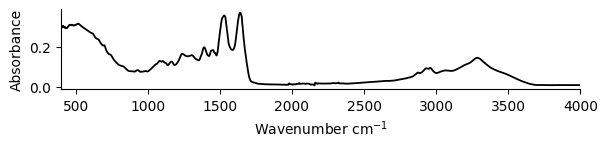

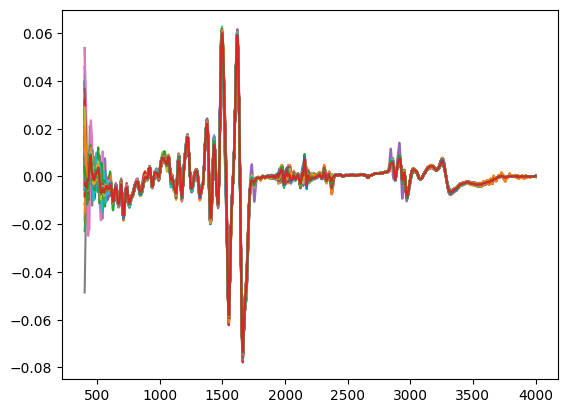

In [26]:
df = pd.read_csv('data/dataset.csv')
domain = pd.read_csv('data/domain.csv')
domain = np.ravel(domain)

#df = df[df['HbA1c'] < 10]
max_abs = df.drop(columns=['HbA1c', 'years']).apply(lambda row: True if row.max() > 0.3 else False, axis=1)
df = df[max_abs]
#df = df[df['HbA1c'] < 12]
print(len(df))

X = df.drop(columns=['HbA1c', 'years'])
y = df['HbA1c']
# y = df['years']

years = df['years']
X.columns = np.ravel(domain)

plt.figure(figsize=(6.7, 1))
X.mean(axis=0).plot(legend=False, color='k', linewidth=1.3)
plt.ylabel("Absorbance")
plt.xlabel("Wavenumber cm$^{-1}$")
plt.xlim([400, 4000])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(top=1, bottom=0.2)
# plt.savefig("figures/pgf/before_preproc.pgf", transparent=True)
# plt.savefig("figures/before_preproc.png", dpi=200)

#X = X.T.apply(lambda col: np.ravel(rubberband_baseline_cor(col))).T
#X = X.apply(lambda row: row / np.linalg.norm(row), axis=1)
#X = X.apply(lambda row: (row - row.mean()) / row.std(), axis=1)
#X = X.apply(lambda row: detrend_spectrum(row, 1), axis=1)
X = X.T.apply(lambda col: savgol_filter(col, window_length=55, polyorder=2, deriv=1)).T
# X = X.apply(lambda row: (row - row.mean()) / row.std(), axis=1)
X = X.apply(lambda row: row / np.linalg.norm(row), axis=1)
# X = X.apply(lambda row: row / max(row.iloc[1000:]), axis=1)
#X.T.plot(legend=False)
X.T.plot(legend=False)

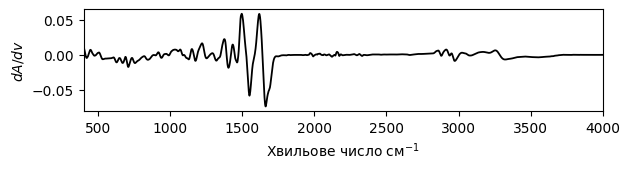

In [27]:
plt.figure(figsize=(6.7, 1.5))
plt.plot(X.mean(axis=0), color='k', linewidth=1.3)
plt.xlim([400, 4000])
plt.xlabel("Хвильове число")
plt.ylabel("Поглинання")

# ax = plt.gca()
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

arrow_properties = dict(arrowstyle='->', color='black', linewidth=1.3)

y_min = -0.0038

# plt.annotate('', xy=(1.03, y_min), xytext=(-0.005, y_min),
#              arrowprops=arrow_properties, 
#              xycoords=('axes fraction', 'data'))

# plt.annotate('', xy=(400, 1.05), xytext=(400, -0.013),
#              arrowprops=arrow_properties, 
#              xycoords=('data', 'axes fraction'))

plt.ylabel(r"$dA/dv$")
plt.xlabel("Хвильове число см$^{-1}$")
#plt.yticks([])
#ax.set_yticklabels([])
plt.subplots_adjust(bottom=0.2)

# plt.savefig("figures/pgf/first_derivative_ftir.pgf", transparent=True)
# plt.savefig("figures/first_derivative_ftir.png", dpi=200)

In [28]:
bio = np.where((domain > 800) & (domain < 1800))[0]
bio

array([ 830,  831,  832, ..., 2901, 2902, 2903], dtype=int64)

┌──────────────────────────┐
│       FIT RESULTS        │
├──────────────────────────┤
│ RMSE = 1.0382            │
│ R2 = 0.7004              │
│ R = 0.8390               │
│ Number of components = 7 │
└──────────────────────────┘


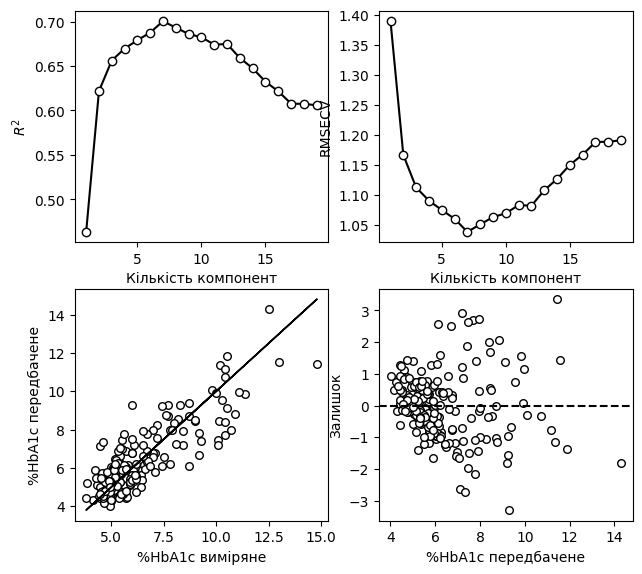

In [29]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform', subsample=None, random_state=24)
categories = discretizer.fit_transform(y.to_numpy().reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, bio], y, test_size=0.3, stratify=categories, random_state=44)

fig, axs = plot_number_components(X_train, y_train, cv=7)
fig.set_size_inches(7.2, 6)
axs[0, 0].set_xlabel("Кількість компонент")
axs[0, 1].set_xlabel("Кількість компонент")
axs[0, 1].set_ylabel("RMSECV")
axs[1, 0].set_xlabel("%HbA1c виміряне")
axs[1, 0].set_ylabel("%HbA1c передбачене")
axs[1, 1].set_xlabel("%HbA1c передбачене")
axs[1, 1].set_ylabel("Залишок")
plt.subplots_adjust(bottom=0.1, top=0.95)
# fig.savefig("figures/training.pgf", transparent=True)

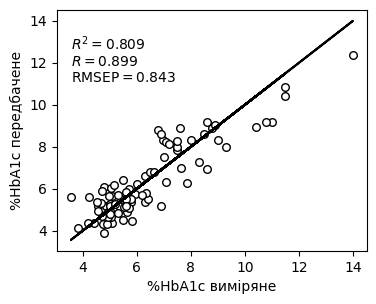

In [30]:
pls = PLSRegression(n_components=6)
pls.fit(X_train, y_train)
y_pred = pls.predict(X_test)
fig, axs = plsr_r2_plot(y_test, y_pred)
fig.set_size_inches(4, 2.8)
axs.set_xlabel("%HbA1c виміряне")
axs.set_ylabel("%HbA1c передбачене")
plt.subplots_adjust(bottom=0.14, top=1)
# fig.savefig("figures/validation.pgf", transparent=True)

Text(0.5, 0, 'wavenumber')

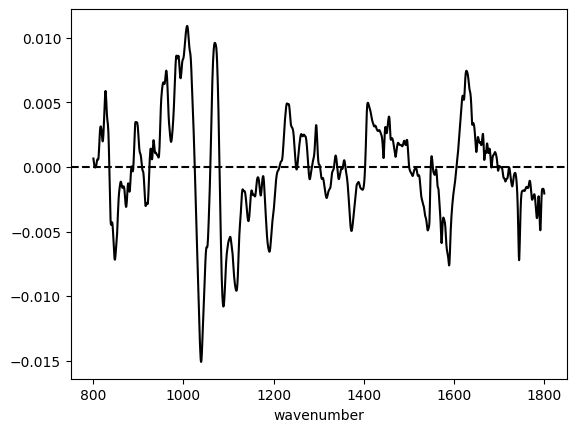

In [31]:
plt.plot(domain[bio], pls.coef_[0], color='k', linewidth=1.5)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel("wavenumber")
#plt.ylabel("regression coefficient")

Text(0, 0.5, 'loadings')

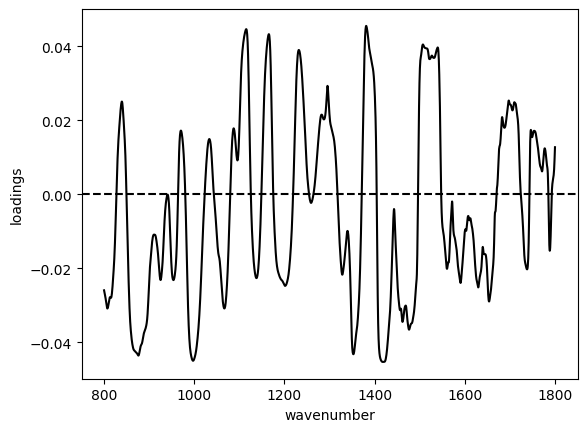

In [32]:
plt.plot(domain[bio], pls.x_loadings_[:, 0], color='k', linewidth=1.5)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel("wavenumber")
plt.ylabel("loadings")

In [33]:
db = y_test.copy()
db[y_test >= 6.5] = 1
db[y_test < 6.5] = 0
db

242    0.0
138    0.0
384    1.0
53     0.0
27     1.0
      ... 
379    1.0
114    0.0
451    1.0
118    0.0
256    0.0
Name: HbA1c, Length: 89, dtype: float64

In [34]:
db_pred = y_pred.copy()
db_pred[y_pred >= 6.5] = 1
db_pred[y_pred < 6.5] = 0
db_pred

array([0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0.])

In [35]:
accuracy_score(db, db_pred)

0.9550561797752809

In [36]:
np.ravel(domain)[850:2900]

array([ 809.9694,  810.4515,  810.9336, ..., 1796.878 , 1797.36  ,
       1797.843 ])